In [1]:
import sys
sys.path.append('C:\\Users\\c0846720\\OneDrive - Lambton College\\Documents')
    
import python_utils
import pandas as pd 
import numpy as np
import datetime as dt
import pyodbc
from tqdm import tqdm
from typing import List
from pathlib import Path
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from enrolment_utils import queries_as_of, data_manipulation_as_of, custom_sharepoint, OCAS_data, data_manipulation_historical
from enrolment_utils import probs_target_utils, side_files_handling, apps_confs_progression, global_params
from enrolment_utils import data_manipulation_as_of

Importing plotly failed. Interactive plots will not work.
11:09:24 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\c0846720\.cmdstan\RTools40


CmdStan install directory: C:\Users\c0846720\.cmdstan
CmdStan version 2.34.1 already installed
Test model compilation


In [245]:
cnxn = python_utils.get_connection()
apps_confs_progression.retrieving_confs_program_per_term_per_date(term = '2023F', 
													date = '2023-01-03', 
													program = 'CDAS', 
													cnxn = cnxn )

[Info] Connection built successfully. Server: CISSQL-live01, database: production. Created on 2024-01-22 at 10:25:57


,ds,y,term
0,2023-01-03,6,2023F


In [77]:
cnxn = python_utils.get_connection()

df_map = data_manipulation_as_of.MapInfo(terms = ['2020F','2021F','2022F','2023F','2024F'], cnxn = cnxn )

def MapInfoQuery(cnxn):

    
    query = """

SELECT 
	--APPL_APPLICANT AS Applicant_ID
	BIRTH_DATE as birth_date
	,GENDER as gender
	,CASE 
		WHEN IMMIGRATION_STATUS = 'NA'
			THEN 'NatAme'
		ELSE 'NotNatAme'
		END AS indigenous_statius
	,CITY
	,ADDRESS.ZIP AS postal_code
	,APPL_ACAD_PROGRAM AS program
	--,APPL_STATUS AS Curr_Status
	,APPL_CHOICE AS program_choice
    ,APPL_START_TERM as term 
FROM APPLICATIONS AA
JOIN APPL_STATUSES BB ON AA.APPLICATIONS_ID = BB.APPLICATIONS_ID
	AND POS = (
		SELECT TOP 1 POS
		FROM APPL_STATUSES
		WHERE APPLICATIONS_ID = AA.APPLICATIONS_ID)
JOIN PERSON P ON APPL_APPLICANT = P.ID
JOIN ADDRESS ON ADDRESS_ID = PREFERRED_ADDRESS
WHERE APPL_START_TERM IN ('2020F','2021F','2022F','2023F','2024F')
ORDER BY APPL_APPLICANT
	,APPL_ACAD_PROGRAM
    """
    query = pd.read_sql(query, cnxn)
    return(query)

dataset = MapInfoQuery(cnxn = cnxn )

dataset = MapInfoQuery(cnxn = cnxn )
dataset['birth_date'] = pd.to_datetime(dataset['birth_date'])

from datetime import datetime


# Function to calculate age on September 1st of the year in the term
def calculate_age_on_sep_first(row):
    # Extract the year from the term (assuming the format is "YYYYF" or "YYYYS")
    year = int(row['term'][:4])
    # Create a datetime object for September 1st of that year
    sep_first = datetime(year, 9, 1)
    # Calculate the age by subtracting the birth_date from the sep_first date and getting the days, then dividing by 365.
    # The floor division '//' returns the full years (age).
    age = (sep_first - row['birth_date']).days // 365
    return age

dataset['age_as_of_sep_first'] = dataset.apply(calculate_age_on_sep_first, axis=1)

dataset['age_group'] = dataset['age_as_of_sep_first'].apply(lambda x:  '<18' if x<19 else 
                                                           '18-21' if (x>18)&(x<22) else
                                                            '22-25' if (x>21)&(x<26) else
                                                            '26-30' if (x>24)&(x<31) else
                                                            '31-40' if (x>29)&(x<41) else
                                                            '41-50' if (x>39)&(x<51) else '>50' )

dataset['postal_code'] = dataset['postal_code'].str[:3]

dataset = dataset.drop('birth_date', axis = 1)

dataset.to_excel('demographics_report.xlsx', index = False)

[Info] Connection built successfully. Server: CISSQL-live01, database: production. Created on 2023-12-07 at 10:43:35


In [230]:
# Importing auxiliary files (order and order end of cycle)
sharepoint_base_url = 'https://mylambton.sharepoint.com/sites/EnrolmentDashboard'

order = custom_sharepoint.sharepoint_download(sharepoint_base_url = sharepoint_base_url,
                                              local_folder = 'orders',
                                              file_name = 'order_winter.txt')

# terms = ['2020W','2021W','2022W','2023W', '2024W']
terms = ['2020S','2021S','2022S','2023S', '2024S']
# terms = ['2020F','2021F','2022F','2023F','2024F']

In [29]:
## OCAS province comparison 
dataset = OCAS_data.sharepoint_download_excel_OCAS( sharepoint_base_url = sharepoint_base_url,
                                                            report_name = 'province_report_fall.xlsx' )

dataset = OCAS_data.OCAS_enrolment_report_province(dataset = dataset)

# OCAS_data.OCAS_enrolment_report_province_format(dataset = dataset, terms = terms)
dataset

4,college_name,mtcu_code_and_title,college_catchment,application_2022,application_2023,application_2024
1,Algonquin,0 - Unknown,Algonquin,0,2,2
2,Algonquin,0 - Unknown,Canadore,0,0,1
3,Algonquin,0 - Unknown,Centennial,0,0,1
4,Algonquin,0 - Unknown,Conestoga,0,0,0
5,Algonquin,0 - Unknown,Durham,0,0,0
...,...,...,...,...,...,...
23169,St. Lawrence,81401 - Honours Bachelor Of Science - Nursing,Sheridan,2,0,1
23170,St. Lawrence,81401 - Honours Bachelor Of Science - Nursing,St. Lawrence,44,46,39
23171,St. Lawrence,81401 - Honours Bachelor Of Science - Nursing,Fleming,0,0,0
23172,St. Lawrence,81401 - Honours Bachelor Of Science - Nursing,St. Clair,3,0,1


In [30]:
dataset[dataset['college_name'] == 'Lambton']['application_2024'].sum()

315

In [3]:
df_apps = apps_confs_progression.compiling_historical_college(terms = ['2020F','2021F','2022F','2023F','2024F'],
                             folder ='applications')


In [5]:
df = probs_target_utils.program_full_data(program = 'CPET', 
                                  start_year = '2019', 
                                  end_year = '2023',
                                  term = '2024F',
                                  cnxn = cnxn,
                                  folder_name = 'registrations')

<AxesSubplot:xlabel='ds', ylabel='y'>

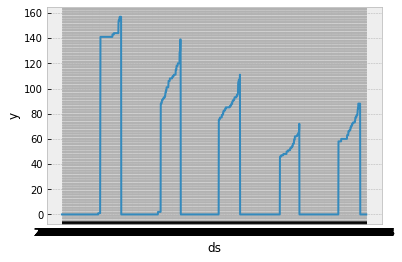

In [7]:
sns.lineplot(x = 'ds', y = 'y', data = df)

In [8]:
probs_target_utils.getting_target_probabilities_program(program = 'CPET', 
                                  start_year = '2019', 
                                  end_year = '2023',
                                  term = '2024F',
                                  cnxn = cnxn,
                                  file_name_budget = 'budget_fall.txt')

11:59:06 - cmdstanpy - INFO - Chain [1] start processing
11:59:11 - cmdstanpy - INFO - Chain [1] done processing
11:59:11 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
11:59:11 - cmdstanpy - INFO - Chain [1] start processing
11:59:13 - cmdstanpy - INFO - Chain [1] done processing
11:59:13 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization: 

In [30]:
data_manipulation_as_of.total_registrations(order = order, 
                    terms = terms, 
                    cnxn = cnxn )

,Program,School,Total Registrations 2020W,Total Registrations 2021W,Total Registrations 2022W,Total Registrations 2023W,Total Registrations 2024W
0,BMAN,Business/Liberal,101.0,75.0,154.0,165,203
1,BMIB,Business/Liberal,110.0,76.0,235.0,217,365
2,GASX,Business/Liberal,28.0,29.0,19.0,19,36
3,LIBI,Business/Liberal,0.0,0.0,0.0,3,8
4,LIBS,Business/Liberal,18.0,14.0,15.0,10,8
5,PARA,Fire / Health / Community,85.0,96.0,88.0,106,101
6,PHRM,Fire / Health / Community,74.0,56.0,93.0,100,115
7,PRAC,Nursing,132.0,126.0,155.0,189,191
8,FSQS,Technology/Trades,0.0,0.0,35.0,109,128
9,BCAS,Technology/Trades,0.0,0.0,15.0,80,83


In [31]:
queries_as_of.xstl_query_term_level_campus('2024W','0', cnxn)

,student_id,first_name,last_name,birth_date,gender,acad_level,imm_status,city,postal_code,location,program,AAL,current_load,tenth_day_load,curr_status,status_date
0,0004516,Joshua,Grant,1982-01-16,M,PS,CA,Sarnia,N7T7H3,MAIN,PHRM,04,T,None,N,2023-05-23
1,0004996,Kristine,Donnelly,1978-07-03,F,PS,CA,Sarnia,N7V1Y6,MAIN,OAHS,04,T,None,N,2023-05-23
2,0005821,Scott,Chrzanowski,1979-01-20,M,PS,CA,Corunna,N0N1G0,MAIN,CTEC,04,T,None,N,2023-05-19
3,0006476,Erin,Beasley,1982-06-26,F,PS,CA,London,N6J 0A9,MAIN,SSWK,04,T,None,N,2023-05-23
4,0016001,Jordan,Brown,1986-12-16,M,AP,CA,Sarnia,N7S 3X6,MAIN,STMA,01,T,None,N,2023-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135,0942059,Hunter,George,1995-06-28,M,AP,None,Sarnia,N7T 7H1,MAIN,CARB,01,T,None,N,2023-10-04
5136,0942064,Brady,Bustin,2003-02-11,M,AP,None,Thamesville,N0P 2K0,MAIN,CARB,01,T,None,N,2023-10-04
5137,0942152,Tristen,Salisbury,1998-04-17,M,AP,None,Oil Springs,N0N 1P0,MAIN,CARB,01,T,None,N,2023-10-05
5138,0942625,Ryleigh,Vanderwal,2001-08-31,M,AP,None,Wyoming,N0N 1T0,MAIN,CARB,01,T,None,N,2023-09-19


# final numbers dashboard

In [7]:
dataframe_apps = pd.DataFrame()

In [8]:
terms =[f'{year}{intake}' for year in range(2017, 2024) for intake in ['W','S','F']]

In [9]:
cnxn = python_utils.get_connection()
for term in terms:
    dataframe_apps = dataframe_apps.append(queries_as_of.ApplicationsQuery(term = term, number = '0', cnxn = cnxn))

[Info] Connection built successfully. Server: CISSQL-live01, database: production. Created on 2024-01-09 at 13:03:55


In [10]:
order = pd.DataFrame({'Program':list(dataframe_apps['Program'].unique())})

In [11]:
start_year = 2018
end_year = 2024
report_name = {
    'fall': [f'{year}F.xlsx' for year in range(start_year, end_year)], 
    'winter': [f'{year}W.xlsx' for year in range(start_year, end_year)],
    'summer': [f'{year}S.xlsx' for year in range(start_year, end_year)]
}

In [12]:
df = custom_sharepoint.sharepoint_download_excel(sharepoint_base_url = 'https://mylambton.sharepoint.com/sites/EnrolmentDashboard/',
                                                         file_name= '2023F.xlsx',
                                                         folder = 'snapshots/fall')

In [20]:
# Empty list to collect all the DataFrames
all_dfs = []

# Iterate over each season and its corresponding terms
for season, terms in report_name.items():
    for term in tqdm(terms):
        # Your provided lines of code
        df = custom_sharepoint.sharepoint_download_excel(sharepoint_base_url = 'https://mylambton.sharepoint.com/sites/EnrolmentDashboard/',
                                                         file_name= term,
                                                         folder = f'snapshots/{season}')
        df['Student Visa'] = df['Student Visa'].fillna('domestic')
        df['Student Visa'] = df['Student Visa'].map({'SV':'international', 'domestic':'domestic'})
        df = df[~df['Student Load'].isin(['C','T'])]
        df = df[['Student ID','Program', 'AAL', 'Student Visa','Student Load']].groupby(['Program', 'AAL', 'Student Visa','Student Load']).count().reset_index()
        df['term'] = term[:-1][0:5]  # Extract the year from the term
        
        # Append the DataFrame to the list
        all_dfs.append(df)

# Optionally, you can concatenate all the DataFrames into one
final_df = pd.concat(all_dfs, ignore_index=True)

final_df['Program'] = final_df['Program'].str[0:4]

final_df = pd.pivot_table(final_df, 
                          values = 'Student ID', 
                          index = ['Program', 'Student Visa','AAL','Student Load'], 
                          columns = ['term'], 
                          aggfunc="sum").fillna(0).reset_index()

programs_schools = global_params.program_school_dict(file_name = 'order_fall.txt')
final_df['School'] = final_df['Program'].map(programs_schools)

100%|██████████| 6/6 [00:32<00:00,  5.34s/it]


In [22]:
python_utils.sort_term_columns(final_df[final_df['Program']=='WELD'])

term,Program,Student Visa,AAL,Student Load,School,2018W,2018S,2018F,2019W,2019S,...,2020F,2021W,2021S,2021F,2022W,2022S,2022F,2023W,2023S,2023F
1178,WELD,domestic,1.0,F,Technology/Trades,10.0,0.0,31.0,0.0,0.0,...,31.0,0.0,0.0,26.0,0.0,0.0,29.0,0.0,0.0,37.0
1179,WELD,domestic,1.0,P,Technology/Trades,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1180,WELD,domestic,2.0,F,Technology/Trades,23.0,8.0,0.0,26.0,0.0,...,0.0,22.0,0.0,0.0,19.0,0.0,0.0,25.0,0.0,0.0
1181,WELD,domestic,2.0,O,Technology/Trades,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1182,WELD,domestic,2.0,P,Technology/Trades,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1183,WELD,international,1.0,F,Technology/Trades,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1184,WELD,international,2.0,F,Technology/Trades,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
output_root = Path.cwd()/'final_numbers_report.xlsx'
terms =[f'{year}{intake}' for year in range(2017, 2024) for intake in ['W','S','F']]
with pd.ExcelWriter(output_root, engine='xlsxwriter') as writer:
    data_manipulation_historical.AppsEndofCycle(order = order, 
                                            terms = terms, 
                                            cnxn = cnxn ).to_excel(excel_writer = writer,
                                                                   sheet_name='apps',
                                                                   index=False)

    data_manipulation_historical.OffersEndofCycle(order = order,
                                                  terms = terms,
                                                  cnxn = cnxn ).to_excel(excel_writer = writer,
                                                                         sheet_name='offers',
                                                                         index=False)

    data_manipulation_historical.ConfirmationsEndofCycle(order = order, 
                                                         terms = terms,
                                                         cnxn = cnxn ).to_excel(excel_writer = writer,
                                                                                sheet_name='confs',
                                                                                index=False)
    final_df.to_excel(excel_writer = writer,
                      sheet_name = 'regs',
                      index = False)

In [ ]:
OffersEndofCycle
ConfirmationsEndofCycle

In [26]:
pd.DataFrame({'program':'WELD'}, index = [0])

,program
0,WELD


In [28]:
terms = [f'{year}{intake}' for year in range(2017, 2024) for intake in ['W','S','F']]

In [30]:
data_manipulation_historical.AppsEndofCycle(order = pd.DataFrame({'Program':'WELD'}, index = [0]), 
                                            terms = terms, 
                                            cnxn = cnxn )

,Program,Applications 2017W,Applications 2017S,Applications 2017F,Applications 2018W,Applications 2018S,Applications 2018F,Applications 2019W,Applications 2019S,Applications 2019F,...,Applications 2020F,Applications 2021W,Applications 2021S,Applications 2021F,Applications 2022W,Applications 2022S,Applications 2022F,Applications 2023W,Applications 2023S,Applications 2023F
0,WELD,0.0,0.0,118,20,0.0,116,18,0.0,103,...,125,0.0,0.0,101,0.0,0.0,135,0.0,0.0,160


# Fixing probabilities of hitting targets

In [8]:
from enrolment_utils import custom_sharepoint, apps_confs_progression, global_params
from prophet import Prophet
import python_utils
import pandas as pd
import pyodbc
from tqdm import tqdm
from scipy.stats import norm
from io import StringIO

from office365.runtime.auth.authentication_context import AuthenticationContext
from office365.sharepoint.client_context import ClientContext
from office365.sharepoint.files.file import File

from datetime import datetime, timedelta

from shareplum import Office365
from shareplum import Site
from shareplum.site import Version

In [9]:
def getting_individual_dates(start_date: str, 
                             end_date: str):
    """
    This function creates the dates within a dates range given in %yyyy-%mm-%dd format 
    
    Args: 
        start_date (str): Start date in %yyyy-%mm-%dd format 
        end_date (str): End date in %yyyy-%mm-%dd format 
        
    Returns: 
        list of dates between start and end dates
    
    Example Usage: 
        getting_individual_dates(start_date = '2020-01-01', 
                         end_date = '2021-01-01')
    """
    
    # Setting input dates
    start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')

    # Creating and arranging dates
    date_list = [start_date_obj + timedelta(days=x) for x in range(0, (end_date_obj - start_date_obj).days + 1)]
    date_list = [date.strftime('%Y-%m-%d') for date in date_list]

    return date_list;

In [10]:
def creating_dates_per_term(start_year:int, end_year:int, term:str) -> dict:
    """
    This function would build dictionaries containing dates for enrolment cycles. 
    For past years, it would provide the end and start dates, for current cycle, will get dates as of today.
    
    args: 
        start_year (int): Start year
        end_year (int): End year
        term (str): current enrolment term
    
    Returns: 
        dictionary containing start and end dates for enrolment cycles
        
    Example Usage: 
        creating_dates_per_term(start_year = 2020, 
                                end_year = 2023, 
                                term = '2023F')
    """
    # Getting current date and year
    current_year = datetime.now().year
    current_date = datetime.now().date().isoformat()
    
    
    # end_date_map = {
    #     'F': "-09-20",
    #     'W': "-01-06",
    #     'S': "-05-06"
    # }
    
    # start_date_map = {
    #     'F': "-09-21",
    #     'W': "-01-05",
    #     'S': "-05-05"
    # }

    # Creating dictionary through dict comprehension
    end_date_map, start_date_map = global_params.start_end_term_dates()
    dates_dict = {
        f"{year+1}{term[-1]}": {
            "start_date": f"{year}{start_date_map[term[-1]]}",
            "end_date": f"{year+1}{end_date_map[term[-1]]}"
        }
        for year in range(start_year, end_year)
    }

    # Adjust the 'end_date' for the term year
    if int(term[:-1]) == current_year + 1:
        dates_dict[term]['end_date'] = current_date

    # Ensure the 'end_date' for the year before the term year matches the start of the term year
    if int(term[:-1]) - 1 in [year for year in range(start_year, end_year)]:
        prev_term = str(int(term[:-1]) - 1) + term[-1]
        dates_dict[prev_term]['end_date'] = dates_dict[term]['start_date']

    return dates_dict;


In [11]:
def final_enrolment_day_be_term(term: str): 
    """
    This function computes the number of days before hitting day 10th of enrolment cycle
    
    Args: 
        term (str): Term of interest
    
    Returns: 
        Integer number of days until day 10th of enrolment cycle
    """
    # Tipically, day 10th will be on the 20th of the starting month 
    if term[-1]=='F':
        end_date = datetime(int(term[:4]), 9, 20)
    elif term[-1]=='W': 
        end_date = datetime(int(term[:4]), 1, 20)
    elif term[-1]=='S': 
        end_date = datetime(int(term[:4]), 5, 20)
    
    # All reporting should be made based on the current day the code is run. 
    periods = (end_date - datetime.now()).days
    
    # In case number is not positive, correct that so it would not crash 
    if periods<= 0:
        periods = 1
        
    return periods

In [12]:
def program_full_data(program:str, 
                      start_year:int, 
                      end_year:int, 
                      term: str,
                      cnxn: pyodbc.Connection = None, 
                      folder_name = 'registrations'):
    """
    This function gets full historical data for a given program. If there is no program file with data, creates it. 
    It there is program file, it updates it with missing dates. 
    
    Args: 
        program (str): Program of interest to retrieve data.
        start_year (int): start year to start tracking historical data
        end_year (int): start year to start tracking historical data
        term (str): Term of interest 
        cnxn (pyodbc.Connection): Connection to retrieve data from (set as None by default)
        
    Returns: 
        Dataframe (pd.DataFrame) with dates and number of registrations. 
    
    Example Usage:     
        program_full_data(program = 'ACTG', term = '2023F)
    """
    
    # Creating connection if none is provided
    if cnxn is None: 
        cnxn = python_utils.get_connection()
        
    files, folder = custom_sharepoint.list_files_in_sharepoint(term = term, 
                                                               folder = folder_name)

    program_file = program + '.txt'
    if program_file in files: 
        # Get the file from SharePoint
        byte_content = folder.get_file(program_file)

        # Convert byte string to a regular string
        content_str = byte_content.decode('utf-8')

        # Convert string to a pandas DataFrame
        dataframe = pd.read_csv(StringIO(content_str), delimiter='\t')

        # Collecting missing dates
        missing_dates = getting_individual_dates(start_date = dataframe['ds'].dropna().iloc[-1], 
                                                end_date = datetime.today().date().strftime(format = '%Y-%m-%d'))
	


        # Retrieving data from missing dates
        df_update = pd.DataFrame()
        for date in missing_dates:
            # Making sure only missing dates are added
            if date not in [x for x in dataframe['ds']]:
                if folder_name == 'registrations':
                    df_update = df_update.append(apps_confs_progression.retrieving_regs_program_per_term_per_date(program = program, 
                                                                                          term = term, 
                                                                                          date = date, 
                                                                                          cnxn = cnxn))
                if folder_name == 'applications':
                    df_update = df_update.append(apps_confs_progression.retrieving_apps_program_per_term_per_date(program = program, 
                                                                                          term = term, 
                                                                                          date = date, 
                                                                                          cnxn = cnxn))
                if folder_name == 'confirmations':
                    df_update = df_update.append(apps_confs_progression.retrieving_confs_program_per_term_per_date(program = program, 
                                                                                          term = term, 
                                                                                          date = date, 
                                                                                          cnxn = cnxn))
                    
        # putting it all together
        dataframe = dataframe.append(df_update)

        # Fixing date format 
        dataframe['ds'] = pd.to_datetime(dataframe['ds'], format = '%Y-%m-%d')

        # Convert DataFrame to CSV in-memory and then upload
        output = StringIO()
        dataframe.to_csv(output, sep = '\t', index=False)
        csv_content = output.getvalue().encode('utf-8') # Convert to bytes-like object

        # Upload/update the document
        folder.upload_file(csv_content, program_file)

    if program_file not in files: 
        # Building program information
        if folder_name == 'registrations':
            df_final = apps_confs_progression.building_program_record(program = program,
                                            start_year = start_year, 
                                            end_year = end_year,
                                            term = term,
                                            cnxn = cnxn)
        if folder_name == 'applications':
            df_final = apps_confs_progression.building_program_record_apps(program = program,
                                            start_year = start_year, 
                                            end_year = end_year,
                                            term = term,
                                            cnxn = cnxn)
        if folder_name == 'confirmations':
            df_final = apps_confs_progression.building_program_record_confs(program = program,
                                            start_year = start_year, 
                                            end_year = end_year,
                                            term = term,
                                            cnxn = cnxn)
            
        # Convert DataFrame to CSV in-memory and then upload
        output = StringIO()
        df_final.to_csv(output, sep = '\t', index=False)
        csv_content = output.getvalue().encode('utf-8') # Convert to bytes-like object

        # Upload/update the document
        folder.upload_file(csv_content, program_file)

    # Get the file from SharePoint
    byte_content = folder.get_file(program_file)

    # Convert byte string to a regular string
    content_str = byte_content.decode('utf-8')

    # Convert string to a pandas DataFrame
    dataframe = pd.read_csv(StringIO(content_str), delimiter='\t')

    return dataframe

In [13]:
getting_target_probabilities_program(program = 'BGEN',
                                    start_year = 2018, 
                                    end_year = 2024,
                                    term = '2024F',
                                    file_name_budget = 'budget_fall.txt')

[Info] Connection built successfully. Server: CISSQL-live01, database: production. Created on 2024-01-11 at 10:23:08


10:23:21 - cmdstanpy - INFO - Chain [1] start processing
10:23:21 - cmdstanpy - INFO - Chain [1] done processing


,program,probability,projected_regs
0,BGEN,0.5,0


In [127]:
def getting_target_probabilities_program(program:str, 
                                         start_year:int, 
                                         end_year:int,
                                         term: str, 
                                         file_name_budget: str,
                                         cnxn: pyodbc.Connection = None):
    """
    This function creates a forecasted value for target value and a probability to reach target for a given program
    
    Args: 
        program (str): Program of interest to retrieve data.
        start_year (int): start year to start tracking historical data
        end_year (int): start year to start tracking historical data
        term (str): Term of interest
        file_name_budget (str): file containing budget numbers of interest
        cnxn (pyodbc.Connection): Connection to retrieve data from (set as None by default)
        
    Returns: 
        Dataframe (pd.DataFrame) with program and probability of reaching target value
    
    Example Usage: 
        getting_target_probabilities_program(program = 'BGEN', term = '2023F')
    

    """
    # Importing Sharepoint credentials
    sharepoint_user, sharepoint_password =  python_utils.load_credentials(sharepoint = True)

    # Importing budget data (sharepoint)
    target  = custom_sharepoint.sharepoint_download(sharepoint_base_url = 'https://mylambton.sharepoint.com/sites/EnrolmentDashboard/',
                                                 local_folder = 'budgets', 
                                                 file_name = file_name_budget, 
                                                 col2_name = 'target')
    
    # If no connection is provided, create one
    if cnxn is None: 
        cnxn = python_utils.get_connection()

    # Getting programs historical data
    dataframe = program_full_data(program = program, 
                                  start_year = start_year, 
                                  end_year = end_year,
                                  term = term,
                                  cnxn = cnxn,
                                  folder_name = 'registrations')
    # apps 
    program_full_data(program = program, 
                                  start_year = start_year, 
                                  end_year = end_year,
                                  term = term,
                                  cnxn = cnxn,
                                  folder_name= 'applications')
    
	# confs
    program_full_data(program = program, 
                                  start_year = start_year, 
                                  end_year = end_year,
                                  term = term,
                                  cnxn = cnxn,
                                  folder_name= 'confirmations')
    # Creating and fitting model 
    
    model = Prophet() # Thanks facebook! 
    model.fit(dataframe)

    # Counting number of days to reach end of cycle 
    periods = final_enrolment_day_be_term(term = term)

	# Forecasting to the data up to end of enrolment cycle (september 20)
    future = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)

	# Keeping forecasted values
    mask = (forecast['ds'] > datetime.now().date().strftime(format = '%Y-%m-%d'))

	# Importing target values from target file
    target_value = int(float(target.loc[target['Program']==program, 'target'].values[0]))

	# If current registrations is greater than target value, prob of reaching target is trivially 1
    if dataframe.iloc[-1]['y'] >= target_value: 
        prob = 1
    else:
	    # Creating probability based on distribution of forecasted values (assumption: normality)
        prob =0.5 #1-norm.cdf(target_value, loc=forecast.loc[mask, 'yhat'].mean(), scale=forecast.loc[mask, 'yhat'].std())

	# Projected number of registrations
    projected_regs = dataframe.iloc[-1]['y']

	# Building dataframe
    dataframe = pd.DataFrame({'program':program, 'probability':prob, 'projected_regs':projected_regs }, index = [0])
		
    return dataframe;

In [187]:
program = 'BMAN'
start_year = 2018 
end_year = 2024
term = '2024W'
cnxn = python_utils.get_connection()

[Info] Connection built successfully. Server: CISSQL-live01, database: production. Created on 2024-01-12 at 10:48:22


In [188]:
df_test  = program_full_data(program = program, 
                                  start_year = start_year, 
                                  end_year = end_year,
                                  term = term,
                                  cnxn = cnxn,
                                  folder_name = 'registrations')

In [56]:
# df_test

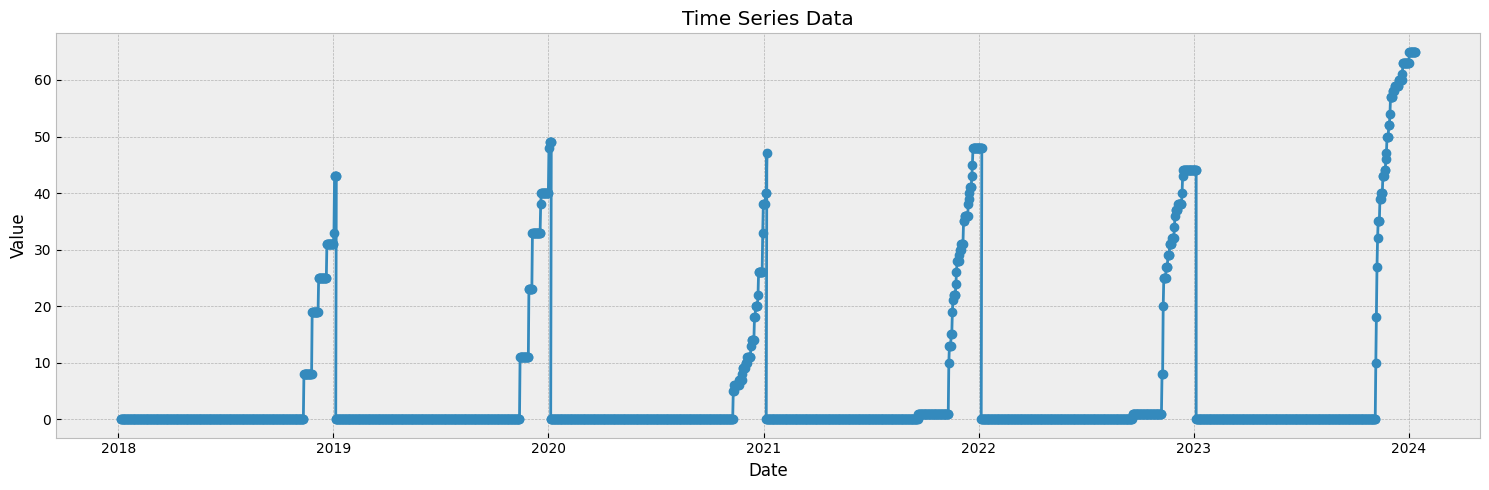

In [189]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has been loaded properly with 'ds' as datetime and 'y' as values

# Make sure 'ds' is of datetime type for proper plotting
df_test['ds'] = pd.to_datetime(df_test['ds'])

# Plotting the time series data
plt.figure(figsize=(15, 5)) # Set the figure size as desired
plt.plot(df_test['ds'], df_test['y'], marker='o', linestyle='-') # marker and linestyle are optional
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True) # Show grid
plt.tight_layout() # Adjust the padding between and around subplots
plt.show()


In [190]:
model = Prophet() # Thanks facebook! 
model.fit(df_test)



10:48:35 - cmdstanpy - INFO - Chain [1] start processing
10:48:36 - cmdstanpy - INFO - Chain [1] done processing


In [191]:
# Counting number of days to reach end of cycle 
periods = final_enrolment_day_be_term(term = term)+14

In [192]:
future = model.make_future_dataframe(periods = periods)
forecast = model.predict(future)

In [193]:
target  = custom_sharepoint.sharepoint_download(sharepoint_base_url = 'https://mylambton.sharepoint.com/sites/EnrolmentDashboard/',
                                                 local_folder = 'budgets', 
                                                 file_name = 'budget_winter.txt', 
                                                 col2_name = 'target')

In [194]:
# Importing target values from target file
target_value = int(float(target.loc[target['Program']==program, 'target'].values[0]))

In [195]:
target_value

75

In [196]:
today = datetime.now().date()
if periods < 30: 
    two_months_ago = today - timedelta(days=60)
    mask = (forecast['ds'] > two_months_ago.strftime(format = '%Y-%m-%d'))
else:
    mask = (forecast['ds'] > today.strftime(format = '%Y-%m-%d'))

In [201]:
forecast.loc[mask, 'yhat'].mean()

32.500665594313205

In [165]:
# forecast

In [163]:
# df_test

In [179]:
df_test.iloc[-1]['y']

65

In [180]:
target_value

75

In [181]:
if df_test.iloc[-1]['y'] >= target_value:
    prob = 1
else:
	    # Creating probability based on distribution of forecasted values (assumption: normality)
        # prob =0.5 
    prob = 1-norm.cdf(target_value, loc=forecast.loc[mask, 'yhat'].mean(), scale=forecast.loc[mask, 'yhat'].std())

In [198]:
prob

0.0017199615261273005

In [185]:
# forecast
baseline = int((int(forecast.loc[mask, 'yhat'].max())+int(forecast.loc[mask, 'yhat'].min()))/2)
if baseline < df_test.iloc[-1]['y']: 
    projected_regs =  df_test.iloc[-1]['y']
else: 
    projected_regs =  baseline

In [186]:
projected_regs

65

In [115]:
df_test.iloc[-1]['y']

65

In [148]:
int(forecast.loc[mask, 'yhat'].max())

52

In [116]:
int((int(forecast.loc[mask, 'yhat'].max())+int(forecast.loc[mask, 'yhat'].min()))/2)

14

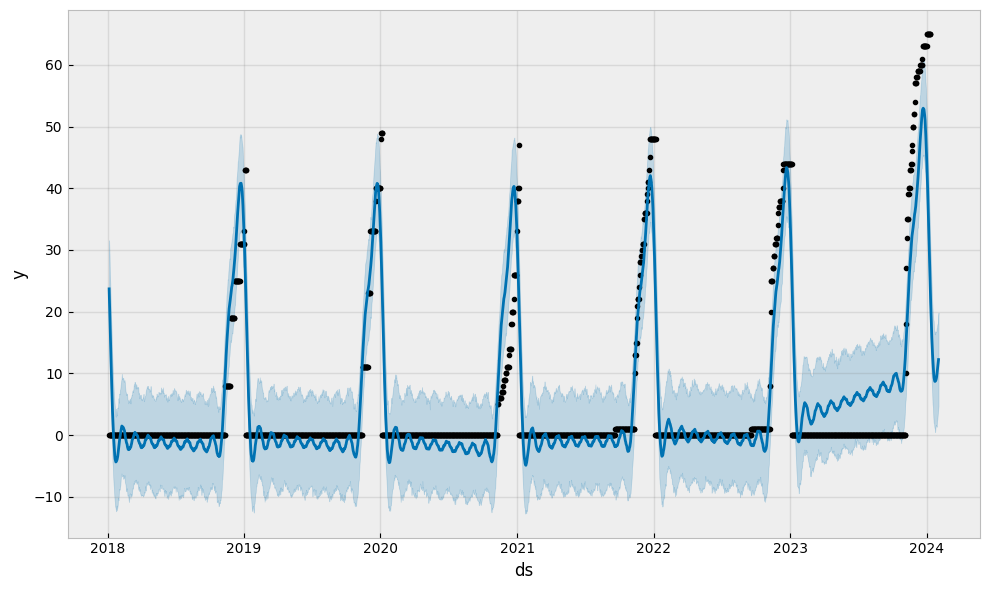

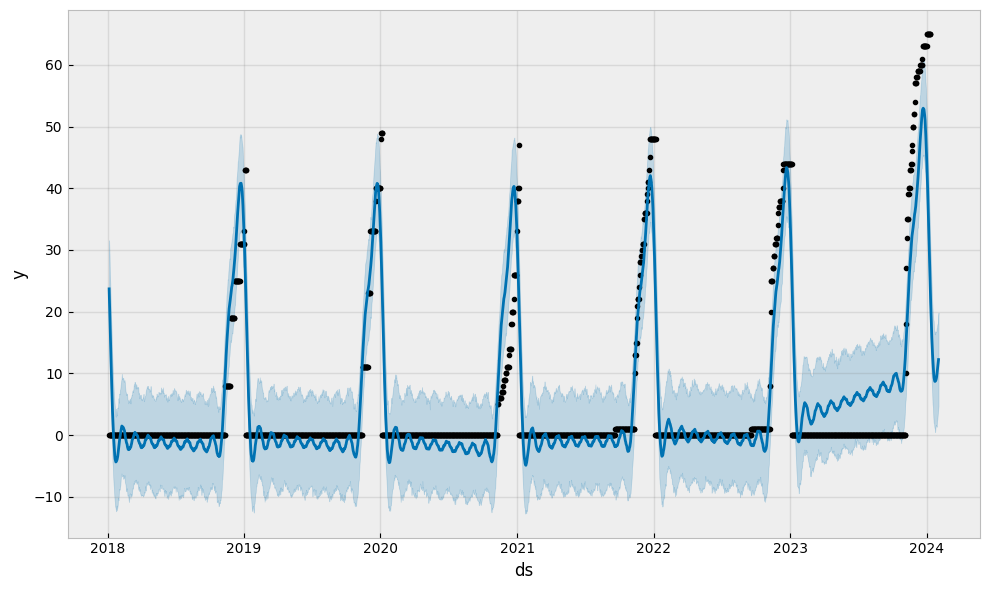

In [150]:
model.plot(forecast)

In [97]:
total_registrations = python_utils.xstl_query_term_level_campus(term = '2024F', 
																 cnxn  = cnxn)

[Info] Data Retrieved on 2024-01-11 at 14:28:30


In [98]:
total_registrations

,student_id,first_name,last_name,birth_date,term,gender,acad_level,imm_status,city,postal_code,location,program,AAL,current_load,tenth_day_load,curr_status,status_date


## Including program names

In [237]:
def program_information(order: pd.DataFrame,
                        cnxn = None):
    """
    This functions creates a spreadsheet with all program names and codes

    Args: 
        cnxn (None): connection.

    Returns:   
        pd.DataFrame with two columns. 
    """

    if cnxn is None: 
        cnxn = python_utils.get_connection()

    query = """
    SELECT XPGM.XPGM_PROGRAM as program
    	,ACPG_TITLE as program_title
    	--,ACPG_ACAD_LEVEL AS program_level
    	--,ACPG_STATUS AS status
    	--,XPGM_MTCU_CODE AS mctu_Code
    	--,XPGM_APS_SEQ_NUM AS aps_seq
    	--,XPGM_BOARD_APPROVED AS board_appr
    	--,XPGM_COST_RECOVERY AS cost_recovery
    	--,XPGM_CIP AS cip
    	--,ACPG_LOCATIONS AS location
    	--,CCDS_ID + ' ' + CCD_DESC AS program_credentials
    	--,
    	-- Getting the WILL Program identifiers
    	--REPLACE(REPLACE(REPLACE((
    	--				CAST((
    	--						SELECT XPLS.XPGM_KPI_WORK_INTEGRATED AS X
    	--						FROM XPROGRAM_LS AS XPLS
    	--						WHERE XPLS.XPGM_PROGRAM = XPGM.XPGM_PROGRAM
    	--						FOR XML PATH('')
    	--						) AS VARCHAR(4000))
    	--				), '</X><X>', ' / '), '<X>', ''), '</X>', '') AS experiential_learning
    -- End WILL Selection
    FROM XPROGRAM XPGM
    LEFT JOIN PROGRAM_STATUS ON XPGM.XPGM_PROGRAM = ACAD_PROGRAMS_ID
    LEFT JOIN ACAD_PROGRAMS ON ACAD_PROGRAMS.ACAD_PROGRAMS_ID = XPGM.XPGM_PROGRAM
    LEFT JOIN ACAD_PROGRAMS_LS ON ACAD_PROGRAMS_LS.ACAD_PROGRAMS_ID = ACAD_PROGRAMS.ACAD_PROGRAMS_ID
    LEFT JOIN CCDS ON ACPG_CCDS = CCDS_ID
    WHERE PROGRAM_STATUS.POS = 1
    	AND XPGM.XPGM_PROGRAM NOT LIKE '%.%'
        -- AND ACPG_STATUS = 'A' -- only keep active programs
    	AND ACAD_PROGRAMS_LS.POS = 1
    
    """
    dataframe = pd.read_sql(query, cnxn)
    dataframe = dataframe[dataframe['program'].isin(list(order['Program'].unique()))]
    return dataframe

In [238]:
program_information(order = order)

[Info] Connection built successfully. Server: CISSQL-live01, database: production. Created on 2024-01-16 at 12:03:28


,program,program_title
82,BCAS,Biomaterials and Chemical Laboratory Analysis ...
127,BMAN,Business Management
139,BMIB,Business Management - International Business
402,FSQS,Food Safety and Quality Assurance Management
424,GASX,General Arts and Science - One-Year
586,LIBI,Liberal Studies (indigenous Pathway)
587,LIBS,Liberal Studies
697,PARA,Paramedic
728,PHRM,Pharmacy Technician
751,PRAC,Practical Nursing


In [339]:
import math

In [270]:
class Shape: 
    def area(self):
        pass
    def perimetro(self): 
        pass

In [285]:
class Rectangulo(Shape):
    def __init__(self, base: int, altura:int)-> None: 
        self.base = base
        self.altura = altura

    def area(self) -> int:
        return self.base*self.altura

    def perimetro(self) -> int:
        return 2*self.base+2*self.altura
        

In [304]:
class Cuadrado(Rectangulo): 
    def __init__(self,lado): 
        self.lado = lado
        super().__init__(lado, lado)

    def __str__(self): 
        return f'Hola, soy un cuadrado de lado {self.lado}'

    def __repr__(self): 
        return f'Objeto del tipo Cuadrado'

In [368]:
class Circulo(Shape): 
    def __init__(self, radio:int)-> None: 
        self._radio = radio
    
    # @staticmethod
    def area(self): 
        return math.pi*self.radio**2
        
    @property
    def radio(self): 
        return self._radio

    @radio.setter
    def nuevo_radio(self, radio2): 
        self._radio = radio2

    

In [369]:
Circulo.area(radio = 2)

TypeError: area() got an unexpected keyword argument 'radio'

In [370]:
ejemplo_circulo = Circulo(radio = 4)

In [372]:
ejemplo_circulo.nuevo_radio = 3

In [373]:
ejemplo_circulo.area()

28.274333882308138

In [305]:
ejemplo = Rectangulo(base = 3, altura = 5)

In [306]:
ejemplo.perimetro()

16

In [307]:
ejemplo_cuadrado = Cuadrado(lado = 6)

In [308]:
ejemplo_cuadrado.perimetro()

24

In [313]:
ejemplo_cuadrado

Objeto del tipo Cuadrado

In [379]:
import requests

def get_users() == : 
    response = requests.get("https://jsonplaceholder.typicode.com/users")
    if response.status_code == 200:
        return response
    
    raise requests.HTTPError

In [6]:
cnxn = python_utils.get_connection()

[Info] Connection built successfully. Server: CISSQL-live01, database: production. Created on 2024-01-29 at 14:07:02


In [10]:
dataframe = queries_as_of.ApplicationsQuery(term = '2024F', 
                                         number = '0', cnxn = cnxn )

In [34]:
dataframe[(dataframe['Program']== 'SRAM')]

,Applicant_ID,Program,Level,status
429,0790772,SRAM,01,CUC
575,0856863,SRAM,01,ACU
697,0875076,SRAM,01,ACU
748,0892480,SRAM,01,WAC
820,0901612,SRAM,01,ACU
...,...,...,...,...
4046,0952101,SRAM,01,ACC
4080,0952167,SRAM,01,ACU
4085,0952172,SRAM,01,ACC
4143,0952272,SRAM,01,ACC


In [48]:
import requests
import json

In [139]:
def get_data(): 
    import requests
    res = requests.get('https://randomuser.me/api/')
    res = res.json()
    res = res['results'][0] 
    return res

def format_data(res): 
    data = {}
    data['first_name'] = res['name']['first']
    data['last_name'] = res['name']['last']
    location = res['location']
    data['address'] = f'{location["street"]["number"]}, {location["street"]["name"]}.{location["city"]}, {location["state"]}. {location["country"]}'
    data['postcode'] = location['postcode']
    data['email'] = res['email']
    data['username'] = res['login']['username']
    data['dob'] = res['dob']['date']
    data['registered_date'] = res['registered']['date']
    data['phone'] = res['phone']
    data['picture'] = res['picture']['medium']

    return data

In [141]:
res =  get_data()
format_data(res)

{'first_name': 'Peggy',
 'last_name': 'Meyer',
 'address': '6892, Fairview St.Richmond, Maryland. United States',
 'postcode': 22419,
 'email': 'peggy.meyer@example.com',
 'username': 'organicbutterfly794',
 'dob': '1992-12-26T20:59:39.420Z',
 'registered_date': '2011-08-20T13:24:06.075Z',
 'phone': '(981) 263-8538',
 'picture': 'https://randomuser.me/api/portraits/med/women/35.jpg'}

In [5]:
cnxn = python_utils.get_connection()

[Info] Connection built successfully. Server: CISSQL-live01, database: production. Created on 2024-02-14 at 09:11:23


In [42]:
    query = """ select XPGM.XPGM_PROGRAM as program_code
            --,ACPG_TITLE as program_title
            --,ACPG_ACAD_LEVEL as academic_level
            --,ACPG_STATUS as status
            ,XPGM_MTCU_CODE as mctu_code
            --,XPGM_APS_SEQ_NUM as aps_seq
            --,XPGM_BOARD_APPROVED as board_appro
            --,XPGM_COST_RECOVERY as cost_recovery
            --,XPGM_CIP as cip
            --,ACPG_LOCATIONS as location
            --,CCDS_ID + ' ' + CCD_DESC AS program_credential,
            -- Getting the WILL Program identifiers
                --REPLACE(REPLACE(REPLACE((CAST(
                --    (SELECT XPLS.XPGM_KPI_WORK_INTEGRATED AS X 
                 --       FROM XPROGRAM_LS AS XPLS
                   --         WHERE XPLS.XPGM_PROGRAM = XPGM.XPGM_PROGRAM
                   --     FOR XML PATH('')
                   -- )AS VARCHAR(4000))),'</X><X>', ' / '),'<X>', ''),'</X>','') AS WILL
            -- End WILL Selection
        from XPROGRAM XPGM left join PROGRAM_STATUS on XPGM.XPGM_PROGRAM = ACAD_PROGRAMS_ID 
                LEFT JOIN ACAD_PROGRAMS on ACAD_PROGRAMS.ACAD_PROGRAMS_ID = XPGM.XPGM_PROGRAM 
                LEFT JOIN ACAD_PROGRAMS_LS ON ACAD_PROGRAMS_LS.ACAD_PROGRAMS_ID = ACAD_PROGRAMS.ACAD_PROGRAMS_ID 
                LEFT JOIN CCDS ON ACPG_CCDS = CCDS_ID
            where PROGRAM_STATUS.POS = 1 and XPGM.XPGM_PROGRAM not like '%.%' AND ACAD_PROGRAMS_LS.POS = 1
        """ 
    df_programs = pd.read_sql(query, cnxn )
    file_name = 'order_fall.txt' ## This is the most comprehensive list of programs out of the three intakes, useful for ocas net movement tab.
    program_school_dict = global_params.program_school_dict(file_name = file_name)
        
    # # Keeping programs offered in current term with MCTU only
    df_programs = df_programs[df_programs['program_code'].isin(list(program_school_dict.keys()))]
    df_programs = df_programs[~df_programs['mctu_code'].isnull()]
    df_programs['mctu_code'] = df_programs['mctu_code'].astype(int)
    
    # # Filling OCAS data with MCTU data
    programs_dict = df_programs.set_index('mctu_code')['program_code'].to_dict()
    
    # Pulling school/program data
    dataframe['mctu_code'] = dataframe['mtcu_code_and_title'].str.split('-').str[0]
    dataframe['lambton_program'] = dataframe['mctu_code'].astype(int).map(programs_dict)
    
    return dataframe

In [44]:
 ## OCAS province comparison 
sharepoint_base_url = 'https://mylambton.sharepoint.com/sites/EnrolmentDashboard/'
report_name_OCAS = 'province_report_fall.xlsx'
dataset = OCAS_data.sharepoint_download_excel_OCAS( sharepoint_base_url = sharepoint_base_url,
                                                            report_name = report_name_OCAS )

dataset = OCAS_data.OCAS_enrolment_report_province(dataset = dataset)

In [ ]:
def OCAS_net_movement(dataframe:pd.DataFrame, 
                      terms: List[str], 
                      cnxn = None):
    """
    This function gets the net movement throughout the provice of Ontario based on MCTU number and matching
    it with those of the program offered by Lambton
    
    Args: 
        dataframe (pd.DataFrame): processed OCAS data (output of OCAS_data.OCAS_enrolment_report_province)
        terms (List[str]): list of terms of interest (would take the last letter of last element, as proxy to intake)
    """
    # if terms[-1][-1] == 'W':
    #     dataframe.columns = [update_colname(col) for col in dataframe.columns]
    # if terms[-1][-1] == 'S':
    #     dataframe.columns = [update_colname(col) for col in dataframe.columns]
    

    query = """ select XPGM.XPGM_PROGRAM as program_code
        --,ACPG_TITLE as program_title
        --,ACPG_ACAD_LEVEL as academic_level
        --,ACPG_STATUS as status
        ,XPGM_MTCU_CODE as mctu_code
        --,XPGM_APS_SEQ_NUM as aps_seq
        --,XPGM_BOARD_APPROVED as board_appro
        --,XPGM_COST_RECOVERY as cost_recovery
        --,XPGM_CIP as cip
        --,ACPG_LOCATIONS as location
        --,CCDS_ID + ' ' + CCD_DESC AS program_credential,
        -- Getting the WILL Program identifiers
            --REPLACE(REPLACE(REPLACE((CAST(
            --    (SELECT XPLS.XPGM_KPI_WORK_INTEGRATED AS X 
             --       FROM XPROGRAM_LS AS XPLS
               --         WHERE XPLS.XPGM_PROGRAM = XPGM.XPGM_PROGRAM
               --     FOR XML PATH('')
               -- )AS VARCHAR(4000))),'</X><X>', ' / '),'<X>', ''),'</X>','') AS WILL
        -- End WILL Selection
    from XPROGRAM XPGM left join PROGRAM_STATUS on XPGM.XPGM_PROGRAM = ACAD_PROGRAMS_ID 
            LEFT JOIN ACAD_PROGRAMS on ACAD_PROGRAMS.ACAD_PROGRAMS_ID = XPGM.XPGM_PROGRAM 
            LEFT JOIN ACAD_PROGRAMS_LS ON ACAD_PROGRAMS_LS.ACAD_PROGRAMS_ID = ACAD_PROGRAMS.ACAD_PROGRAMS_ID 
            LEFT JOIN CCDS ON ACPG_CCDS = CCDS_ID
        where PROGRAM_STATUS.POS = 1 and XPGM.XPGM_PROGRAM not like '%.%' AND ACAD_PROGRAMS_LS.POS = 1
    """ 
    df_programs = pd.read_sql(query, cnxn )
    
    # Keeping those programs with MCTU only
#     df_programs = df_programs[['XPGM_PROGRAM', 'MTCU_Code']]
    df_programs = df_programs[~df_programs['mctu_code'].isnull()]
#     df_programs.columns = ['program', 'mctu']
    df_programs['mctu_code'] = df_programs['mctu_code'].astype(int)
    
    # Filling OCAS data with MCTU data
    programs_dict = df_programs.set_index('mctu_code')['program_code'].to_dict()
    dataframe['mctu_code'] = dataframe['mtcu_code_and_title'].str.split('-').str[0]
    dataframe['lambton_program'] = dataframe['mctu_code'].astype(int).map(programs_dict)
    
    # Pulling school/program data
    testing_dict = global_params.naming_files()
    # file_name = [data['file_name_order'] for season, data in testing_dict.items() if data['terms'] == terms][0]
    file_name = 'order_fall.txt' ## This is the most comprehensive list of programs out of the three intakes, useful for ocas net movement tab.
    program_school_dict = global_params.program_school_d']ict(file_name = file_name)
    dataframe['lambton_school'] = dataframe['lambton_program'].map(program_school_dict)
    return dataframe